# Simple Linear Regression
We use the advertising dataset given in ISLR book and analyse the relationship between `TV advertising` and `sales` using a simple linear regression model

## Import necessary libraries

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

## Load dataset and have initial look and feel

In [2]:
df = pd.read_csv('advertising.csv')
df.head(5)

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
TV           200 non-null float64
Radio        200 non-null float64
Newspaper    200 non-null float64
Sales        200 non-null float64
dtypes: float64(4)
memory usage: 6.4 KB


## Visualise data

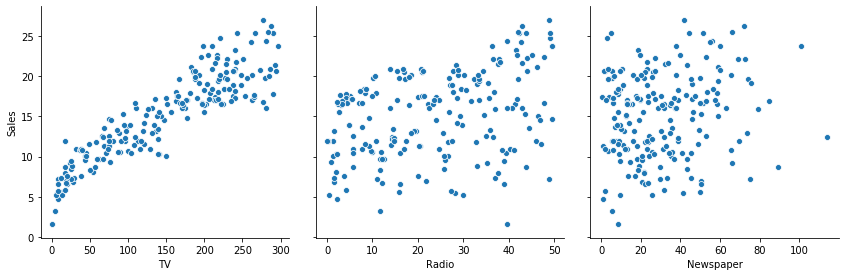

In [4]:
sns.pairplot(df, x_vars=['TV', 'Radio', 'Newspaper'], y_vars='Sales', height=4, aspect=1)
plt.show()

The scatter plot suggests linear relationship between TV and Sales

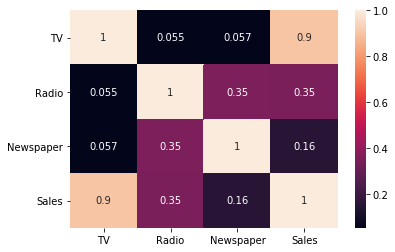

In [5]:
sns.heatmap(df.corr(), annot=True)
plt.show()

The heatmap confirms that we have strong positive correlation between TV and sales

## Model building using statsmodels

### Prepare X and y

In [6]:
X = df['TV']
y = df['Sales']

### Train test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=100)

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((140,), (140,), (60,), (60,))

As we are dealing with only one independent variable we dont need normalisation of the data

## Build model using statsmodels

### Adding a constant to get intercept
The statsmodels always fits a line that goes through origin i.e whose intercept is 0. To get a line with an intercept we do a nice hack. We introduce another variable in X which has all elements set to 1. So that any intercept 'c' that we get will multiply with this value 1 and remain as c.

In [9]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [10]:
X_train_sm.head()

,const,TV
74,1.0,213.4
3,1.0,151.5
185,1.0,205.0
26,1.0,142.9
90,1.0,134.3


### Building the mode using  OLS

In [11]:
ols = sm.OLS(y_train, X_train_sm)
reg_results_wrapper = ols.fit()

### Look at the params

In [12]:
reg_results_wrapper.params

const    6.948683
TV       0.054546
dtype: float64

### Lets look at the summary of the regression results wrapper

In [13]:
print(reg_results_wrapper.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     611.2
Date:                Sat, 15 May 2021   Prob (F-statistic):           1.52e-52
Time:                        11:38:05   Log-Likelihood:                -321.12
No. Observations:                 140   AIC:                             646.2
Df Residuals:                     138   BIC:                             652.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9487      0.385     18.068      0.0

####  Looking at some key statistics from the summary

The values we are concerned with are - 
1. The coefficients and significance (p-values)
2. R-squared
3. F statistic and its significance

##### 1. The coefficient for TV is 0.054, with a very low p value
The coefficient is statistically significant. So the association is not purely by chance. 

##### 2. R - squared is 0.816
Meaning that 81.6% of the variance in `Sales` is explained by `TV`

This is a decent R-squared value.

###### 3. F statistic has a very low p value (practically low)
Meaning that the model fit is statistically significant, and the explained variance isn't purely by chance.

### Lets visualise the model

In [53]:
def plot_regline_on_dataset(X, y, model, predictmanually= False):
    '''
    Given a dataset of TV advertising spend and Sales and a trained linear reg model
    We plot the regression line on top the scatter plot.
    predictmanually controls if we predict values manually by using params from model, or 
    we use the predict method of the model.
    Note the model used is statsmodel OLS Regression results wrapper.
    '''
    if predictmanually:
        y_pred = model.params['const'] + model.params['TV'] * X
    else:
        X_sm = sm.add_constant(X)
        y_pred = model.predict(X_sm)
        
    fig = plt.figure()
    fig.suptitle('Regression line fit on dataset')
    plt.scatter(X, y)
    plt.plot(X, y_pred, 'r')#'r' is for a red line
    plt.xlabel('TV advertising spend')
    plt.ylabel('Sales')
    plt.show()

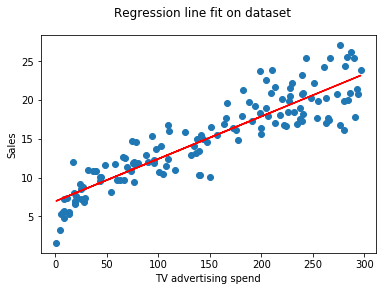

In [54]:
plot_regline_on_dataset(X_train, y_train, reg_results_wrapper, predictmanually=True)

## Residual analysis
- The distribution of residuals can help find us the range of the confidence interval for forecast. In addition to that if the distribution of residuals is skewed we have a few residuals which are very far away from 0,this indicates presence of outliers that can affect the estimation of params. This is because the residuals of these outliers can dispropotionately influence the estimates of the params.
- Also it can helps us find how the line will perform beyond the range of sample data.


### Distribution of residuals

In [15]:
y_train_pred = reg_results_wrapper.predict(X_train_sm)
residuals = y_train - y_train_pred

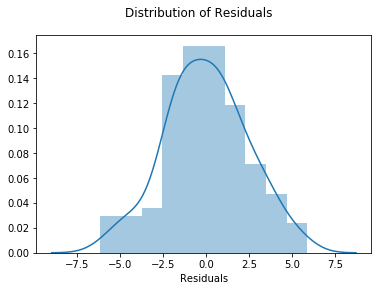

In [26]:
fig = plt.figure()
sns.distplot(residuals)
fig.suptitle('Distribution of Residuals')
plt.xlabel('Residuals')
plt.show()

The residuals are normally distributed. This is a good sign

### Patterns in residuals

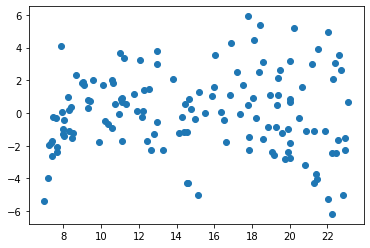

In [27]:
plt.scatter(y_train_pred, residuals)
plt.show()

The variance in residuals has increased with higher values of y_pred. So this variance in residuals is not explained by the model.

Overall we can say that the model is a good fit

### Predictions on test set

In [34]:
y_test_pred = reg_results_wrapper.predict(X_test_sm)

We use sklearn.metrics mean_square_error and r2_score to calculate the metrics on test

In [37]:
mean_squared_error(y_test, y_test_pred)

4.077556371826953

In [38]:
r2_score(y_test, y_test_pred)

0.792103160124566

Visualising the fit on the test set

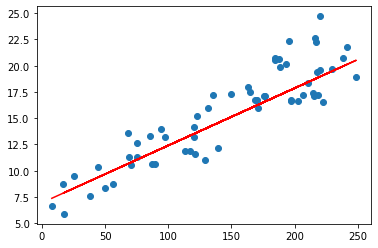

In [46]:
plt.scatter(X_test, y_test)
plt.plot(X_test, y_test_pred, 'r')
plt.show()

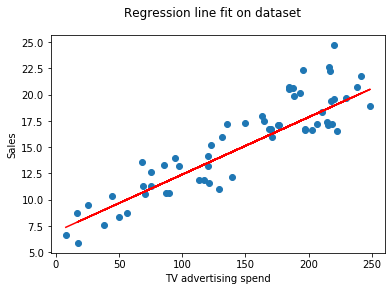

In [57]:
plot_regline_on_dataset(X_test, y_test, reg_results_wrapper, predictmanually=False)